Concavity Measure 3D

All functionalities related to my interface concavity algorithm are included below. They are divided into the following subgroups:

- Main Algorithm: The core algorithm. Takes an input file from oversegment_image.m -- that is, a .mat array of an oversegmented slice via watershed algorithm -- and outputs a numpy array of the same size of the final segmentation as per the algorithm.

- Utilities: Some utility blocks related to the main algorithm: plotting, ground-truth comparison, etc.

- 3D Visualization Output: Code designed to output a result to MayaVi. Comprised of a single function/block that takes in a border key (elaborated upon later) and outputs a .zip file to the cwd. A separate .py file reads this zipfile and displays it with MayaVi.


**NOTE**: Because my work was spread across several files, some of the included blocks in Utilities do not fit in this file's pipeline. For example, the ground-truth comparison utility was created for the Ambrose data -- it won't make sense with other datasets!

**NOTE 2**: This was designed to be run in Google Colab. If running there, you may need to change the %cd statement to make sure it links to **your** working directory in Google Drive. If not running there, you can remove the Google Colab stuff entirely. Assuming you have the necessary files in your cwd, it should work fine.

In [1]:
# imports for below blocks

import zipfile
import matplotlib
import matplotlib.pyplot as plt

# IMPORTANT: this is where you move to your cwd
# if you aren't working in Colab, or have a different cwd, edit/remove these lines
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/Colab\ Notebooks/

from PIL import Image
import numpy as np
import scipy as sp
from sklearn.decomposition import PCA

import os

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


Main Algorithm

The core algorithm is below. I include a description/explanation of each block in text above, and comments in each block for an in-depth explanation of the code's functionality.

This block includes utility functions to visualize slices of the dataset, and loads in the primary dataset.

**NOTE**: There are various options for datasets. The input to this algorithm is an oversegmented watershed transform of such a dataset. Which file to run the algorithm on is determine by the parameter "filename" in the block below. Here are some filenames and their corresponding datasets

- "ambrose" -- Ambrose slice
- "0213" -- the dataset used in my presentation

Additional datasets that I haven't tested much:
- "0160"
- "0184"
- "0206"

Alternatively, you can produce additional .mat files of this format by feeding RGB .tif files into **oversegment_image.m**, which is also included in this directory. If you do this, make sure to rename files properly or tweak the filename format to accept this new test case.

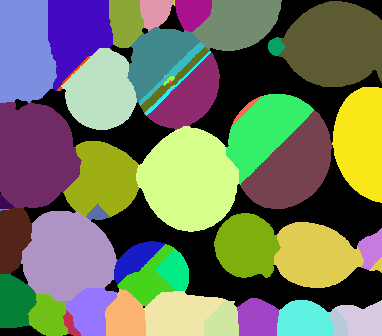

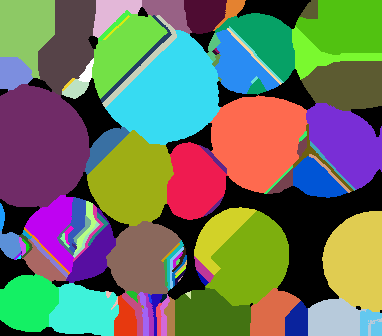

In [2]:
# importing image and converting to grayscale + visible
# giving every color a unique id

# to_color: Utility function used in visualize
# Input: a label present in the oversegmented watershed .mat
# Ouput: a UNIQUE color that visualize will display with
def to_color(n):
  if n == 255:
    return [255, 255, 255]
  return [int(100.3729*n)%256, int(61.276*n)%256, int(113.7187*n)%256]


# visualize: Utility function that visualizes a SLICE of a numpy array
# Input:
# - arr: the SLICE of the array to be visuzlied
# - color: whether to visualize in color. color=True is default and is recommended
# - save: whether to save the visualized slice to the cwd. save=False is default
# Output: None. The visualized slice is displayed via Pillow IMG, and saved to the cwd if save=True
def visualize(arr, color=True, save=False):
  sliced = np.zeros((arr.shape[0], arr.shape[1], 3)) if color else np.zeros((arr.shape[0], arr.shape[1]))

  for i in range(sliced.shape[0]):
    for j in range(sliced.shape[1]):
      if color:
        pixel = to_color(arr[i][j])
        for k in range(3):
          sliced[i][j][k] = pixel[k]

      else:
        if arr[i][j] == 255:
          sliced[i][j] = 255
        else:
          # manual grayscale formula -- designed to give IDs a unique grayscale color
          # still difficult to differentiate -- color=True is recommended
          sliced[i][j] = ((arr[i][j] * 47) % 210) + 30


  display(Image.fromarray(np.uint8(sliced)))
  if save: Image.fromarray(np.uint8(sliced)).save("savedimg.png")


filename = "0160" # CHANGE NAME HERE
# loading in oversegmented watershed .mat -- reading output from oversegment_image.m
# see above description for options present in this directory



arr = sp.io.loadmat(filename + ".mat")["ans"]
arr = arr[30: -30, 30: -30, 30: -30] # removing 30 pixel buffer

# visualizing sample slices
for z in [0, min(100, arr.shape[2]-1)]:
  visualize(arr[:,:,z], color=True)

# grabbing max ID -- this is necessary for later
arrmax = np.max(arr)

Calculating Widths:

Recall as part of the original 'partial prune' algorithm, we threshold segments with low widths into their neighbors with the highest shared surface area.

This block calculates the width of every segment. Specifically, it does the following for each segment:

(1) Masks out everything but the segment currently being measured

(2) Calculates the distance transform of the masked image

(3) Takes the **maximum** of the resultant distance tranform. This results in a single value, considered to be the 'width' of the segment.

**NOTE**: This step is **very time intensive.** This block will usually take a couple hours to complete, and the results of this file are output to to a .txt file. I have included outputs of this block in the folder, so **you do not need to run this block for datasets mentioned above. But you will have to run this block when loading in new datasets.**

<br>

In case a job is interrupted, output.txt is constantly opened/closed to ensure output is saved. when resuming the job, check where output.txt leaves off and modify the **for** loop to resume where you want.

Upon completion, the next block will want the text file to have the name
"[filename]_widths.txt". Make sure to rename output.txt to that before running the next block.


In [ ]:
# This line blanks fht output file, restarting the job from scratch -- keep this in mind
# output = open("output.txt", "w"); output.close()

widths = np.stack((np.arange(0, arrmax+1), np.zeros((arrmax+1))), axis=1)

# if job is interrupted: change the for loop to start in desired location
# example: if output file ends at 250 --> "for i in range(251, arrmax+1):"
for i in range(arrmax+1):
  if i % (arrmax // 20) == 0:
    # print statement that lets me know every 5% completion -- can remove if desired
    print(i, "out of", arrmax, "|||", str(i // (arrmax // 20) * 5) + "% finished :((")

  masked_arr = np.array(list(map(lambda n : n == i, arr))) # masks array

  widths[i][1] = np.max(sp.ndimage.distance_transform_edt(masked_arr)) # calculates distance tranform and takes maximum

  output = open("output.txt", "a") # writes to output file -- updates in cwd after every write
  output.write(str(i) + " " + str(widths[i][1]) + "\n")
  output.close()

widths[0][1] = np.inf # 0 should never be merged -> set it to infinity

0 out of 131 ||| 0% finished :((


KeyboardInterrupt: ignored

In [3]:
# reads in an output file as generated in the previous block
# dependent on filename -- this should have been set in the first block
readin = open(filename + "_widths.txt")

widths = np.stack((np.arange(0, arrmax+1), np.zeros((arrmax+1))), axis=1)
for line in readin.readlines():
  [i, j] = list(map(float, line.split()))
  widths[int(i)][0] = i; widths[int(i)][1] = j

readin.close()

Graph Generation:

The next step is to generate the following information
- A list of the shared surface areas between given cells, to merge cells into the highest surface area neighbor later
- A graph of connected cells, to properly update neighbors. Example: need to merge A -> B, B -> C, A -> D ==> A,B,C,D must all be connected

This block steps through the array one pixel at a time, generating the above information. They are represented as follows:

- **areas**: A [arrmax+1] x [arrmax+1] array, where areas[i][j] holds the number of shared border pixels between segment ID i and segment ID j. Note the following:
  - if i and j do not share a border, areas[i][j] = 0
  - areas is symmetric, i.e. areas[i][j] = areas[j][i] for all i, j

- **graph**: a list of sets of length [arrmax+1]. graph[i] is a set containing the IDs of all segments (NOT INCLUDING 0) touching the segment with ID i.

In [4]:
# defining relevant data structures as described above
areas = np.zeros((arrmax+1, arrmax+1))
graph = [set() for i in range(arrmax+1)]


for k in range(arr.shape[2]-1):

  # prints progress report every 10%
  if k % (arr.shape[2] // 10) == 0:
    print(str(k // (arr.shape[2] // 10) * 10) + "% finished :(")

  for i in range(arr.shape[0]-1):
    for j in range(arr.shape[1]-1):
      curr = arr[i][j][k]
      # adjacency between segment i and segment j is determined by a pixel adjacency check
      # to avoid double-checking, I only extend the check in the +x, +y, and +z direction
      adj_lst = [arr[i+1][j][k], arr[i][j+1][k], arr[i][j][k+1]]
      border = False

      for a in range(len(adj_lst)):
        adj = adj_lst[a]
        # checks if adjacent pixels are nonzero and different
        if (curr != 0 and adj != 0 and curr != adj):
          border = True
          graph[curr].add(adj); graph[adj].add(curr)

      if border: # if so:
        areas[curr][adj] += 1; areas[adj][curr] += 1
        # adds an adjacent pixel to the counter of adjacent pixels between i and j





0% finished :(
10% finished :(
20% finished :(
30% finished :(
40% finished :(
50% finished :(
60% finished :(
70% finished :(
80% finished :(
90% finished :(


The following two blocks are essentially a checkpoint for the **graph** and **areas** data structures.

The block after these two will change **graph** and **areas** as part of its run. At the same time, it depends upon a width_threshold parameter that potentially will want to be tweaked for optimal results.

I have encountered situations where I want to run that block multiple times with different width_threshold values -- but had to regenerate **graph** and **areas** each time, wasting a couple minutes each time. This 'checkpoint' system avoids this.

Running the first block 'saves' **graph** and **areas**. From here, we can run the block below.

When wanting to try a different width_threshold, running the second block will 'load' **graph** and **areas** without having to wait. DO NOT run the first block before the second block -- this will overwrite the 'loaded' structures. (This is why two separate blocks are required.) Then, we can run the third block again.

If you don't reload the data structures before changing width_threshold and re-running, the block will produce a **KeyError**. If reloading via the second block doesn't work, **graph** and **areas** will have to be regenerated.

In [5]:
graph_c = list(map(lambda st : st.copy(), graph))
areas_c = areas.copy()

In [ ]:
graph = list(map(lambda st : st.copy(), graph_c))
areas = areas_c.copy()

Partial Prune:

This performs the partial prune stage as described above: taking the smallest width segments and merging them into their neighbor with the highest shared surface area.

In practice, we sort our list of segment IDs and widths in ascending width order, and carry out the merge one segment at a time. Included is a parameter **width_threshold**: segments with a width under this threshold are merged as above.

When a segment is merged, **graph** and **areas** are updated as follows. The segment being merged is 'merged' and the neighbor into which we are merging is 'best_neighbor.'

<br>

**graph**:
- For each neighbor of 'merged' besides 'best_neighbor':
    - Draw an edge between 'best_neighbor' and the neighbor
    - Remove the edge between 'merged' and the neighbor
- Remove the edge between 'best_neighbor' and 'merged.' Note that 'merged' is effectively excised from the graph.

**areas**:
- For each neighbor of 'merged' besides 'best_neighbor':
  - Add the area counter for the border between 'merged' and the neighbor to the area counter for 'best_neighbor' <-> the neighbor
  - Set the area counter for the neighbor <-> 'merged' to 0
- Set the area counter for 'best_neighbor' <-> 'merged' to 0

IMPORTANT: **areas** is a symmetric square array. So for each of these, I am updating areas['merged']['best_neighbor'] AND areas['best_neighbor']['merged'].

<br>

If a segment is small enough to require merging, but has no neighbors to which it can be merged, it is assumed to be an artifact. As such, it is 'merged' into 0 (airspace).

<br>


The merge itself is carried out via appending to 'merge_list.' This contains a list of 2-arrays of the format [old_ID, new_ID] where old_ID is to be merged into new_ID. Example: in the above case where segments have no neighbors, I append [segment_ID, 0] to merge_list. This merge_list is applied to the actual data via a helper function **produce_reasssigment** and a pass through the array.

The function of produce_reassigment is elaborated upon via comments. Taking in merge_list, it outputs a list of length [arrmax+1]: arrmax[i] contains the ID to which the segment with ID i will be assigned.

<br>

-------

Example: Suppose we have 5 separate cells and the following merge_list:

[[1, 2],
[3, 4],
[4, 2]]

Observe that cells 1, 2, 3, 4 should all be connected, while 5 is separate. Therefore, the output of produce_reassignment will be:

[2, 2, 2, 2, 5]

------

<br>

Finally, I pass through the entire dataset array. Upon encountering a pixel with ID i, I reassign it to index i of the output of produce_reassignment. This produces an updated array merged via the partial prune as above.

Reassignment Time:


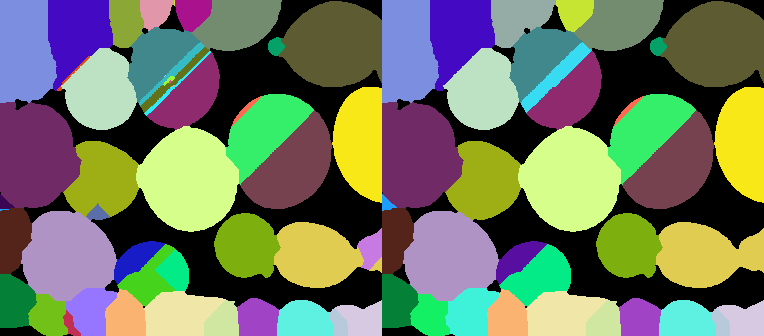

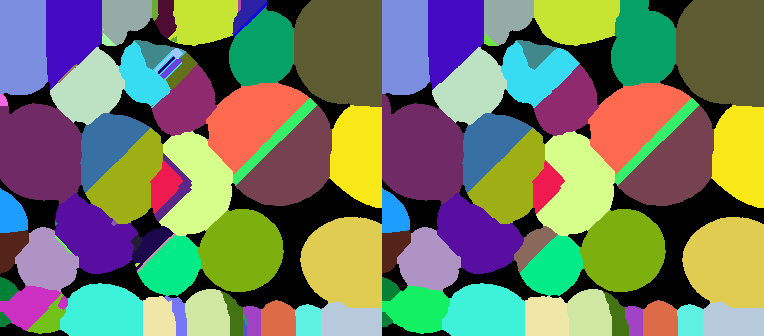

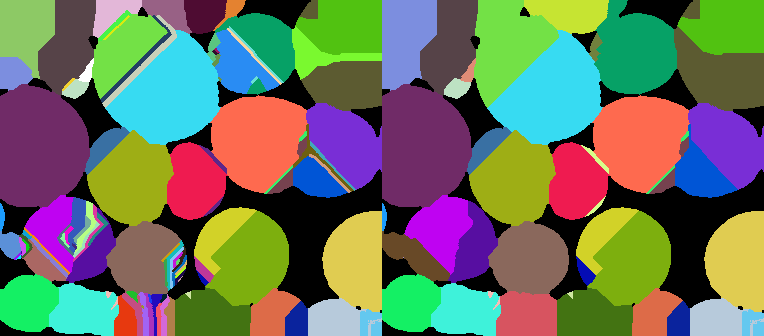

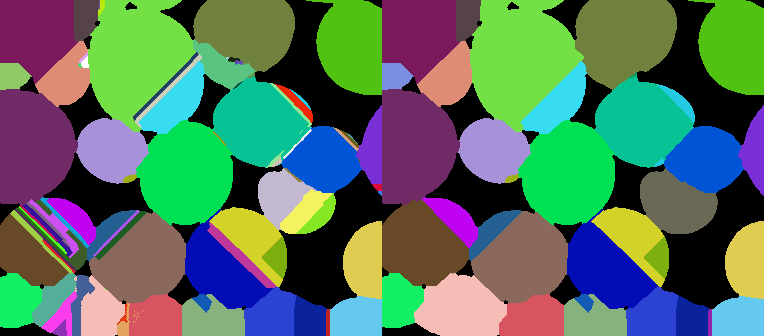

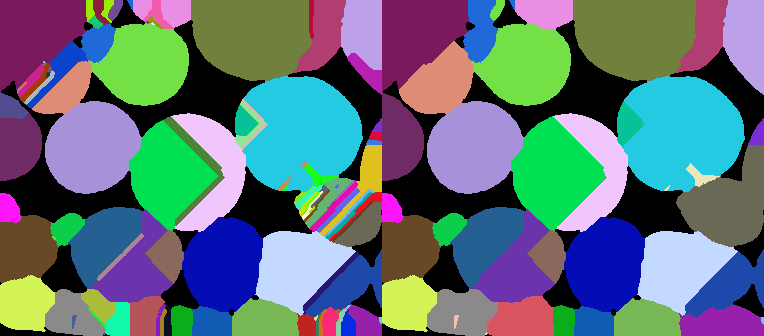

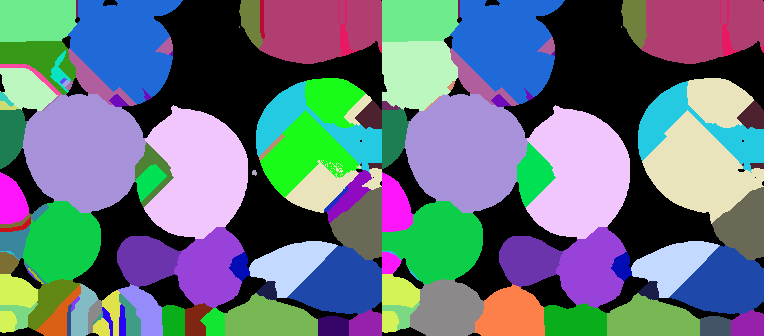

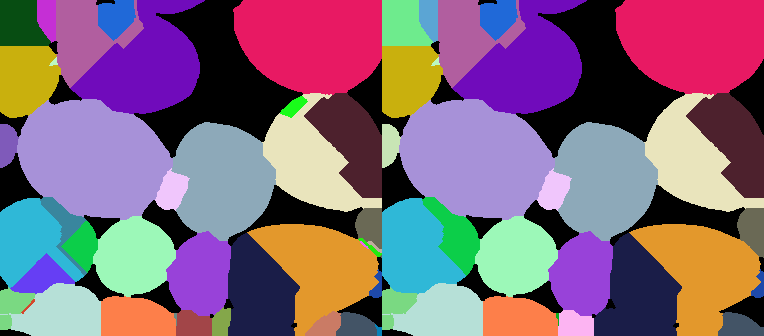

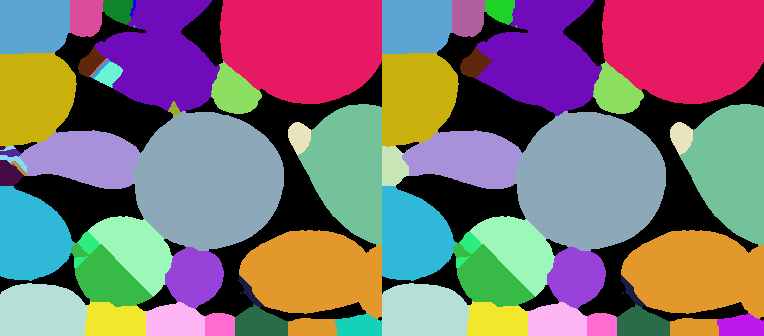

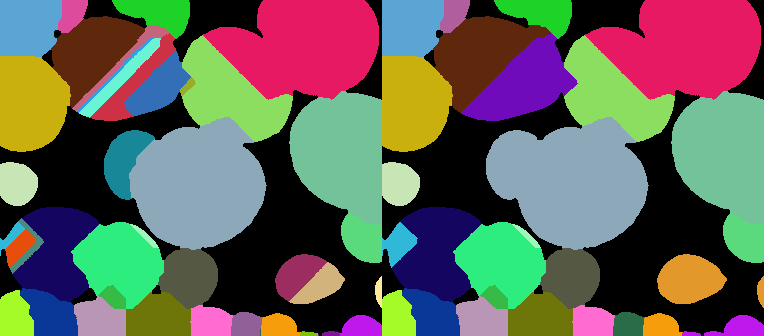

In [6]:
# MAKE SURE TO SET THIS AS DESIRED. IT CHANGES THE FUNCTIONALITY OF THE ALGORITHM
width_threshold = 18 # lower width = less things merged


# produce_reassignment: helper function for partial prune below
# Input:
# - merge_list: List of merges -- [old_ID, new_ID] -- to be carried out
# - n: length of array. n = arrmax in practice
# Output: a list of length [arrmax+1]:
# index i corresponds to the final assigment of segment with ID i
def produce_reassignment(merge_list, n):
  new_list = list(range(n+1))

  # because merges are carried out in chronological order, idea is relatively simple
  # when updating, set all indices currently on 'old' to 'new'
  for [old, new] in merge_list:
    for i in range(n+1):
      if new_list[i] == old: new_list[i] = new

  return new_list



# recall that widths are stored as a list of [ID, width] -- we are sorting by width in ascending order
# (1) sort the list in ascending width order // (2) copy each list in sorted_widths to remove aliasing problem
sorted_widths = list(map(lambda lst : lst.copy(), sorted(widths, key = (lambda lst : lst[1]))))

merge_list = []
for col in range(len(sorted_widths)):
  curr = list(map(int, sorted_widths[col])) # curr = [ID, width] as integer -- recall I'm reading from a text file, so require str->int cast

  if curr[1] > width_threshold: break # break when width_threshold is too high
  if curr[1] == 0: continue # no need to merge if width is 0

  # of all neighbors of 'merged' found in graph, find 'best_neighbor' with highest shared SA
  best_neighbor = -1
  for neighbor in graph[curr[0]]:
    if best_neighbor == -1 or areas[best_neighbor][curr[0]] < areas[neighbor][curr[0]]:
      best_neighbor = int(neighbor)

  # if 'merged' has no neighbors but requires merging, merge with 0
  if best_neighbor == -1:
    merge_list.append([curr[0], 0])

  else:
    # updating of areas and graph as described above
    for prev_link in graph[curr[0]]: # works cuz undirected graph
      if prev_link != best_neighbor:
        graph[prev_link].add(best_neighbor); graph[best_neighbor].add(prev_link)
        graph[prev_link].remove(curr[0])

        areas[prev_link][best_neighbor] += areas[prev_link][curr[0]]; areas[best_neighbor][prev_link] += areas[curr[0]][prev_link]
        areas[prev_link][curr[0]] = 0; areas[curr[0]][prev_link] = 0

    graph[best_neighbor].remove(curr[0])
    areas[curr[0]][best_neighbor] = 0; areas[best_neighbor][curr[0]] = 0

    merge_list.append([curr[0], best_neighbor])


# turn merge_list into a list of reassignments using produce_reassigment (see above)
reassign = produce_reassignment(merge_list, arrmax)
print("Reassignment Time:")

# pass through the array, reassigning new values to pixels via the 'reassign' list
# our final output of the partial prune is 'merged_arr'
merged_arr = np.zeros(arr.shape)
for i in range(arr.shape[0]):
  for j in range(arr.shape[1]):
    for k in range(arr.shape[2]):
      merged_arr[i][j][k] = reassign[int(arr[i][j][k])]

# visualization of different z-slices, for comparison between original watershed and partial prune
# concatenation places them side-by-side for better comparison
for z in range(0, arr.shape[2], 50):
  visualize(np.concatenate((arr[:,:,z], merged_arr[:,:,z]), axis=1), color=True)

Concavity Parameters:

This block contains the parameters for the concavity section of this algorithm. Below is a description of each, though it may not make sense now. I will elaborate further when the parameters come up:

<br>

Recall that the general idea for the algorithm is as follows: We **step** outward parallel to the border from cell matter, then **search** perpendicular to the border back towards cell matter. (See presentation for visualization.)

- **step**: The step distance outward from the cell border, in pixels
- **max_search**: The maximum perpendicular distance IN EACH DIRECTION we will try to search, before terminating, in pixels

<br>

Recall the 3D algorithm searches in various directions. Because our border is a plane, we extend searches in various directions along the plane, emanating from the center of the border. This produces a variety of search distances -- in practice, I produce a list of 32 distances -- which must be compiled into a single 'concavity score.'

Recall that we discussed various ways to do this, and settled on a combination of the median and the mean. 'portion_size' turns this into a parameter.

- **portion_size**: Determines the portion of the array to take the mean of, in the process of determining a single concavity score. Specifically, portion_size takes a parameter between 0 and 1. When portion_size = n, the final concavity score is the **mean of the middle (100n)% of the sorted list of distances**.

<br>

--------
Examples:
- portion_size = 1 --> take the mean of the middle 100% of the array --> take the mean of the entire array
- portion_size = 0.5 --> take the mean of the middle 50% of the array --> take the mean of the 25th percentile -> 75th percentile
- portion_size = 0 --> take the mean of the middle 0% of the array --> take the median of the array
---------

In practice, setting portion_size to between 0 and 0.2 produces good results.

<br>

Recall that when a distance check hits a slice border, we don't know what to do with it. Because we've hit a border, we cannot know our check will encounter cell matter or not beyond. 'throw_out_edge_collision' determines what we do with these checks:

- **throw_out_edge_collision**:
  - If throw_out_edge_collision = True, remove checks that encounter borders from our list of distances. (Our final concavity score will not take them into account.)
  - If throw_out_edge_collision = False, set checks that encounter borders to the maximum search distance. (In other words, assume that they will not encounter another cell.)

In practice, throw_out_edge_collision = True is appropriate for the datasets in sample_segmentations. throw_out_edge_collision = False is appropriate for the Ambrose dataset, and is required to obtain a perfect segmentation.

<br>

Finally, recall that we want to merge convex borders, while keeping concave borders. In other words, borders with higher 'concavity scores' should be merged, and borders with lower 'concavity scores' should be kept. 'max_concav_threshold' is the threshold for this.

- **max_concav_threshold**: The threshold at which segments with higher scores are merge, and segments with lower scores are not.

That being said, I commonly use max_concav_threshold = 1.5 x max_search. Recall the histogram for concavity scores has its 2nd and 3rd peaks at around 1 x max_search and 2 x max_search, and I want to split the 2nd and 3rd peaks (see presentation). 1.5 x max_search works well for this, and in practice on the whole dataset.


<br>
<br>

------------

Finally, here are some parameter values that I found to work well on the test datasets I ran on. They should produce the results that I demonstrated in my presentation.


**Ambrose**:
- width_threshold = 12 (see partial prune stage)
- step = 12
- max_search = 60
- portion_size = 0
- throw_out_edge_collision = False
- max_concav_threshold = 1.5 x max_search


**0213**:
- width_threshold = 12
- step = 8
- max_search = 75
- portion_size = 0.1
- throw_out_edge_collision = True
- max_concav_threshold = 1.5 x max_search


Tentative Parameters (unoptimized) on other datasets:

**0160**:
- width_threshold = 18
- step = 10
- max_search = 75
- portion_size = 0.1
- throw_out_edge_collision = True
- max_concav_threshold = 1.5 x max_search


**0206**:
- width_threshold = 8
- step = 8
- max_search = 75
- portion_size = 0.1
- throw_out_edge_collision = True
- max_concav_threshold = 1.5 x max_search


In [16]:
# width threshold parameter is set above -- change if necessary
step = 10
max_search = 60
portion_size = 0.1
throw_out_edge_collision = True
max_concav_threshold = max_search * 1.5

np.seterr(all='raise')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

3D Analysis Helpers + Plane Fitting:

This block contains two main functionalities:
- 3D Analysis Helpers: Various small helpers that are useful for 3D-space-related math
- Plane Fitting: Fitting a plane to each cell-cell border, in preparation for the concavity checks

For the first, I include a brief description of each 3D helper and its functionality:

- cross_prod: Takes two 3D vectors and returns their cross product.
- normalize: Takes a 3D vector and normalizes it, so that its length is 1.


For the second, recall our core concavity algorithm had 6 steps as decribed in the presentation. This block accomplishes the first two steps:

(1) Sample points from the cell-cell border

(2) From this sample, fit a plane using PCA analysis and henceforth represent the border as this plane

<br>

To do this, I use three dictionaries holding different data. For each dictionary, keys are of the format "i j" (i < j) where each key "i j" holds information relevan to the border between segment ID i and segment ID j.

- **border_dict** is a dictionary containing lists of border pixels for pairs of segments. Specifically, border_dict["i j"] is a list of all border pixels shared by segments i and j.

- **mean_dict** is a dictionary that assists in calculating the mean of the border. mean_dict["i j"] holds the **sum of all pixels in the border across each axis**, for the border between segment ID i and segment ID j.  

That is to say, mean_dict["i j"] = [x, y, z], where x = the sum of the x-values of all pixels in the border, y = the sum of the y-values of all pixels in the border, z = the sum of the z-values of all pixels in the border. We divide by the length of border_dict["i j"] to obtain the mean.

- **plane_dict** is a dictionary containing the planes corresponding to borders in ax + by + cz + d format. plane_dict["i j"] = [a,b,c,d] where the corresponding fit plane to segments i and j is ax + by + cz + d.

<br>

**NOTE**: The correct key for a border between segment ID i and segment ID j is "i j" where i < j. "j i" **will not work**, resulting in a KeyError.

<br>

First, we pass through the array collecting the information required to fill these dictionaries. This is done via a pixel-by-pixel check, and a function **update_dicts**. This function is designed to update **border_dict** and **mean_dict** as described above: It first finds the correct key. Then, it appends the pixel to the corresponding list in **border_dict** and adds the x-value/y-value/z-value to their respective sums in **mean_dict**.

<br>

Second, we iterate through each identified border -- in practice, through the keys contained within **border_dict**. For each, we fit a plane to our border using PCA analysis as below:

(1) Recall that PCA analysis fits an n-dimensional ellipsoid to a set of points. Supposing that our border lies on a plane, our sample of border points should resemble an ellipse. Running PCA with n = 2 returns a major and minor axis for this ellipse. The normal vector to this ellipse (that is, the cross product of these two vectors) is the normal vector to our fit plane.

(2) Then, we calculate the border mean using **mean_dict** as above. While we know our plane's direction (via the normal vector), we don't know a point on which it lies -- so we choose the mean. In practice, this is very easy: Our normal vector is [a,b,c], and we require [a,b,c,d] for our final plane. We simply plug our mean [x,y,z] into ax + by + cz = d to get our final plane.

(3) Finally, we store this plane in **plane_dict**, which is used in the next stages of the algorithm.

<br>

**NOTE:** With very small borders, there is a good chance that PCA analysis fails and produces a drastically wrong result. In practice, very small borders also shouldn't be merged. As such, **when borders contain below 10 pixels**, I simply remove their key from **border_dict**, eliminating it from the concavity stage. Thus it is no longer a candidate from merging as we want.

In [8]:
# cross_prod: Helper for 3D analysis, returns cross product of two 3D vectors
# Input:
# - v1: first 3D vector
# - v2: second 3D vector
# Output: a third 3D vector, being the cross product of v1 and v2
def cross_prod(v1, v2):
  return [v1[1]*v2[2]-v1[2]*v2[1], v1[2]*v2[0]-v1[0]*v2[2], v1[0]*v2[1]-v1[1]*v2[0]]

# normalize: Helper for 3D analysis, returns a normalized version of input vector
# Input: a vector to be normalized
# Output: the normalized vector (length = 1)
def normalize(vector):
  l = (vector[0]**2 + vector[1]**2 + vector[2]**2)**0.5
  return [vector[0] / l,  vector[1] / l, vector[2] / l]


# update_dicts: Updates info dictionaries as part of plane fitting (see above)
# Input:
# - border_dict: See above for format
# - mean_dict: See above for format
# - curr: current pixel being checked
# - adj: adjacent pixel to curr, with border identified between curr <-> adj
# Output: Updated versions of border_dict and mean_dict
def update_dicts(border_dict, mean_dict, curr, adj):
  if curr > adj: curr, adj = adj, curr # RECALL: key must be "i j" where i < j
  curr = int(curr); adj = int(adj)
  key = str(curr) + " " + str(adj)

  # updating dictionaries as described above
  # mean_dict holds [x, y, z] sums, so add pixel x,y,z to corresponding sum
  if key not in mean_dict:
    mean_dict[key] = [i, j, k]
  else:
    mean_dict[key][0] += i; mean_dict[key][1] += j; mean_dict[key][2] += k

  # border_dict holds lists of pixels, so append pixel to corresponding list
  if key not in border_dict:
    border_dict[key] = [(i, j, k)]
  else:
    border_dict[key].append((i, j, k))

  return border_dict, mean_dict # return updated versions of relevant structures


# defining necessary info
masked_arr = np.copy(merged_arr)
border_dict = dict()
mean_dict = dict()
plane_dict = dict()


# pass through the array
for k in range(arr.shape[2]-1):

  if k % (arr.shape[2] // 10) == 0:
    print(str(k // (arr.shape[2] // 10) * 10) + "% finished :(")

  for i in range(arr.shape[0]-1):
    for j in range(arr.shape[1]-1):
      curr = masked_arr[i][j][k]
      adj_lst = [masked_arr[i+1][j][k], masked_arr[i][j+1][k], masked_arr[i][j][k+1]]
      border = False

      # idea is to grab every relevant pixel pair, while taking care not to double count
      # specifically: each 'curr' pixel can belong to multiple "i j" borders (i.e. in "i j" AND "i k")
      # but it should NOT belong to "i j" TWICE.
      # this updates the dictionaries as described above, while keeping this in mind
      bhold = []
      for a in range(len(adj_lst)):
        adj = adj_lst[a]
        if (curr != 0 and adj != 0 and curr != adj) and (curr, adj) not in bhold:
            bhold.append((curr, adj))

      for (curr, adj) in bhold:
        # send each relevant pixel pair identified above to update_dicts
        border_dict, mean_dict = update_dicts(border_dict, mean_dict, curr, adj)


rkeys = [] # keys to remove from dict, if border is too small (see above)
for key in border_dict:
  border_list = border_dict[key]
  borderlen = len(border_list);

  if len(border_list) < 10: # if border is too small, remove key
    rkeys.append(key)
    continue

  # performs PCA analysis, fitting border sample to ellipse (2D ellipsoid)
  pca = PCA(n_components=2)
  pca.fit(border_list)
  normal = cross_prod(pca.components_[0], pca.components_[1]) # format is [a, b, c]

  # calculate mean from mean_dict as above
  mean_list = mean_dict[key]
  mean = (mean_list[0] // borderlen, mean_list[1] // borderlen, mean_list[2] // borderlen)

  # plug mean into [a,b,c] to get [a,b,c,d] final plane, and add final plane to plane_dict
  [a,b,c] = normal; [x,y,z] = mean
  d = a*x + b*y + c*z
  plane = [a,b,c,d]
  plane_dict[key] = plane


# remove keys associated with borders that are too small to be accurate (and shouldn't be merged anyway)
for key in rkeys:
  del border_dict[key]

0% finished :(
10% finished :(
20% finished :(
30% finished :(
40% finished :(
50% finished :(
60% finished :(
70% finished :(
80% finished :(
90% finished :(


Perpendicular Search:

This next block implements the following steps of the algorithm, as described in the presentation:

(3) Decompose into vectors with various rotations along the plane

(4) Extend parallel to these vectors and step outside of cell matter

(5.1) Find perpendicular distances from each extension

<br>

The outputs of this block are as follows:
- **concavities**: The main output -- a dictionary of lists of perpendicular distances. concavities["i j"] (i < j) is a list of the perpendicular distances associated to the border between segment ID i and segment ID j
- **scandict** A dictionary containing intermediary information for the process above. scandict["i j"] (i < j) is a 3-list of lists as follows:
  - scandict["i j"][0] holds pixels belonging to perpendicular checks that are kept (the red lines in MayaVi) associated with segment ID i and segment ID j
  - scandict["i j"[1] holds pixels belopng to perpendicular checks that are thrown out due to border encounter (the light red lines in MayaVi) concerning segment i and segment j
  - scandict["i j"][2] holds the pixels on cell matter from which we step outwards to the perpendicular checks, (the yellow dots in MayaVi) concerning segment i and segment j

A couple things:

(1) Even if throw_out_edge_collisions = False and stuff in scandict["i j"][1] is not thrown out, it will still appear light red.

(2) **scandict** is **not used** in the main algorithm. It was created solely to display the algorithm's behavior in MayaVi. See the MayaVi output block below for more information.

<br>

--------------

<br>

The block carries out the steps above as follows, for each identified border between segment i and segment j:

<br>

It first grabs relevant information from the previous block's data structures (border length, mean <-> center of plane, etc.).

Then, we decompose the plane into 32 unit vectors of uniform rotation along the plane. In practice, we arbitrarily choose a vector v1 lying along the plane (i.e. dot product of [a,b,c] and v1 are 0) -- [-b, a, 0] works most of the time, but we have a failsafe [1, 0, 0] in the case a=0,b=0. We define v2 as the cross-product of [a,b,c] and v1 (normalized), so we have two perpendicular normalized vectors lying on the plane.

From there, we can construct any arbitrary normalized vector lying on the plane by varying theta in cos(theta) x v1 + sin(theta) x v2. Think like the unit circle. We vary theta in increments of pi/16 in [0, 2*pi) -> 32 vectors of various rotations.

<br>

Next, we move parallel to our vectors and step outside of cell matter. In practice, we do this as follows for each vector ***v*** in in the 32 rotated vectors above:

Start from the border center, and start incrementing a **distance** parameter -- the length of the vector. Keep making it bigger (one pixel at a time) until center + v $*$ distance no longer lies in either cell. ('center + v x dist' is a 3-list -- in practice, we are checking that masked_arr [ l[0] ][ l[1] ][ l[2] ] is not either i or j.) We also must check that center + v $*$ distance stays within the slice dimensions as well.

Supposing we remain within the slice borders, we **step** a certain distance further in the direction of v. **This is where the step parameter comes into play.** From here, we will start the perpendicular checks -- this point will also go into scandict["i j"][2].

<br>

We use a similar process here, with a distance parameter that we keep incrementing upwards. Rather than incrementing until we **are not** in segment i or j, now we are incrementing until we **are** in segment i or j. ('curr_vals' is a list [i j] processed from the key "i j" stored in border_dict.) We also ensure that we don't encounter a slice border as above. Finally, if we increment too high without encountering either condition, we terminate the check and return the current value. The value of 'too high' is dictated by the parameter **max_search** (see above).

**NOTE**: The above check proceeds in **two** directions, both parallel to the plane normal ('perpendicular to the plane'). So the above process is carried out twice.

<br>

If both perpendicular searches terminate on the 1st condition (encountering segment i or j), the check is considered valid. The perpendicular distances of both checks are added (so as to be the length of the line connecting cell matter), and this sum is added to our list of perpendicular distances. Every pixel checked for this is added to scandict["i j"][0].

If either check terminates on the 2nd condition (encountering a border), the respective check is automatically set to the **max_search** distance. The sum is calculated as above -- however, whether the sum is **only** added to our list of perpendicular distances if **throw_out_edge_collision** = False. If **throw_out_edge_collision** = True, the sum is omitted from the final list. Regardless, every pixel checked for this is added to scandict["i j"][1].

<br>

Finally, we sort our final list, and output our final data structures **concavities** and **scandict** as above.

In [17]:
concavities = dict()
scandict = dict()

# iterate over every identified border, represented as a key in border_dict
for key in border_dict:

  # getting relevant information to following check
  curr_vals = list(map(lambda s : int(s), key.split())) # [i, j] <-> representing border beteween segment i and segment j

  borderlen = len(border_dict[key])
  mean_list = mean_dict[key]
  plane = plane_dict[key]

  [a, b, c, d] = plane
  mean = (mean_list[0] // borderlen, mean_list[1] // borderlen, mean_list[2] // borderlen)
  center = mean # by current design, plane is automatically centered on mean

  pv = normalize([a, b, c])
  # choose arbitrary vector on plane (dot prod = 0). Need failsafe if pv is [0,0,+-z]
  v1 = normalize([-b, a, 0]) if [pv[0], pv[1]] != [0, 0] else [1, 0, 0]
  v2 = normalize(cross_prod(v1, pv))

  clist = [] # list of concavity scores -> will go into concavities dict
  scanlist = [[mean], [], []] # list of relevant info -> will go into scandict

  for t in range(0, 32):
    theta = np.pi * t / 16
    # decompose into uniform vectors on plane at angle increments of theta = pi/16
    v = np.array(v1) * np.cos(theta) + np.array(v2) * np.sin(theta)

    scanlist_hold = []
    dist = 0

    check_hit_edge = False
    # check is effectively as follows
    # while center + v*dist remains within border slice (each axis) AND the point is still in segment i or segment j, keep incrementing
    while (0 < center[0]+v[0]*dist < arr.shape[0] and 0 < center[1]+v[1]*dist < arr.shape[1] and 0 < center[2]+v[2]*dist < arr.shape[2]
          and masked_arr[int(center[0]+v[0]*dist), int(center[1]+v[1]*dist), int(center[2]+v[2]*dist)] in curr_vals):
      dist += 1

    # if we hit a border slice, mark check as (potentially) invalid
    if not(0 < center[0]+v[0]*dist < arr.shape[0] and 0 < center[1]+v[1]*dist < arr.shape[1] and 0 < center[2]+v[2]*dist < arr.shape[2]):
      check_hit_edge = True

    # we've reached an edge of cell matter
    # add this to scandict[2], and use *step* parameter to move further outwards along vector v
    edge = [round(center[0]+v[0]*dist), round(center[1]+v[1]*dist), round(center[2]+v[2]*dist)]
    scanlist[2].append(edge.copy())
    edge[0] += step * v[0]; edge[1] += step * v[1]; edge[2] += step * v[2]

    # recall we are stepping in two directions -- sd_up and sd_down both lie along the perpendicular check in opposite directions
    sd_up = 0; sd_down = 0
    ins_up = [round(edge[0] + sd_up*pv[0]), round(edge[1] + sd_up*pv[1]), round(edge[2] + sd_up*pv[2])]
    ins_down = [round(edge[0] + sd_down*pv[0]), round(edge[1] + sd_down*pv[1]), round(edge[2] + sd_down*pv[2])]

    # while our checked pixel lies within the border slice (each axis) AND the point is still NOT in segment i or segment j, keep incrementing
    while (0 < ins_up[0] < arr.shape[0] and 0 < ins_up[1] < arr.shape[1] and 0 < ins_up[2] < arr.shape[2]
      and masked_arr[ins_up[0], ins_up[1], ins_up[2]] not in curr_vals
      and sd_up < max_search):

      sd_up += 1
      ins_up = [round(edge[0] + sd_up*pv[0]), round(edge[1] + sd_up*pv[1]), round(edge[2] + sd_up*pv[2])]
      scanlist_hold.append(ins_up)

    # if we encountered a border check, mark check as potentially invalid + set check to maximum search dist
    if not(0 < ins_up[0] < arr.shape[0] and 0 < ins_up[1] < arr.shape[1] and 0 < ins_up[2] < arr.shape[2]):
      check_hit_edge = True; sd_up = max_search

    # (this is the same as the 'up' direction)
    # while our checked pixel lies within the border slice (each axis) AND the point is still NOT in segment i or segment j, keep incrementing
    while (0 < ins_down[0] < arr.shape[0] and 0 < ins_down[1] < arr.shape[1] and 0 < ins_down[2] < arr.shape[2]
      and masked_arr[ins_down[0], ins_down[1], ins_down[2]] not in curr_vals
      and sd_down > -1 * max_search):

      sd_down -= 1
      ins_down = [round(edge[0] + sd_down*pv[0]), round(edge[1] + sd_down*pv[1]), round(edge[2] + sd_down*pv[2])]
      scanlist_hold.append(ins_down)

    # if we encountered a border check, mark check as potentially invalid + set check to maximum search dist
    if not((0 < ins_down[0] < arr.shape[0]) and (0 < ins_down[1] < arr.shape[1]) and (0 < ins_down[2] < arr.shape[2])):
      check_hit_edge = True; sd_down = -1 * max_search

    # if both checks terminated properly, add to scanlist[0] and append sum (sd_down is negative distance) to final clist
    if not check_hit_edge:
      scanlist[0] += scanlist_hold
      clist.append(max([1, sd_up - sd_down]))

    # otherwise, add to scanlist[1] and ONLY append sum if *throw_out_edge_collision* = False
    else:
      scanlist[1] += scanlist_hold
      if not throw_out_edge_collision:
        clist.append(sd_up - sd_down)

  # update relevant info -- recall this was done for each key in border_dict
  # our dictionaries will contain this information for each identified border between cell segments
  concavities[key] = sorted(clist)
  scandict[key] = scanlist

Threshold + Final Merge

We've done most of the work! All that's left are the final steps of the concavity stage:

(5.2) Process list of distances into a single concavity score

(6) Merge borders with concavity scores above a set threshold

We do the above steps as follows:

<br>

First, we process the concavity score differently based on our parameter **portion_size**. Recall that 0 <= portion_size <= 1, and that when portion_size = n --> we take the mean of the middle (100$*$n)% of the sorted list of concavities. As a reminder:

- portion_size = 1 --> take the mean of the middle 100% of the array --> take the mean of the entire array
- portion_size = 0.5 --> take the mean of the middle 50% of the array --> take the mean of the 25th percentile -> 75th percentile
- portion_size = 0 --> take the mean of the middle 0% of the array --> take the median of the array

Here, we simply carry out this process. I elected to choose the geometric mean over the normal mean, as it produces better results. That being said, with portion < 0.2 (my recommended settings), the difference is negligible.

**NOTE**: Recall that checks encountering borders are tossed out. For some borders, it is possible that **all** checks encounter borders and are tossed, leaving an **empty** concavity list. In this case, I simply toss the check by manually setting the final score to 0. This is one reason why undersegmentation appears around our slice borders.

<br>

Second, we come to the merge stage. It follows a similar idea to the previous merge, but is much more compact. It also makes use of a utility function **find_root**.

The main adaptation of this sub-algorithm is that it reorganizes the graph of connected segments (i.e. segments are nodes, segments to be merged are connected) to be acyclic. If we think about it, cycles aren't necessary in this graph -- my previous merge algorithm above (see partial prune) may accidentally create them. This algorithm avoids them, and thus can be a little clearer.

<br>

The function **find_root** takes in an array **arr** of length [arrmax+1] and a start value **val** (corresponding to a segment). For each segment i, **arr** holds the **immediately adjacent** segment j to which i remembers it is merged to. **However,** j is always greater than i -- this avoids cycles!

**find_root** begins with the start value **val**, and searches up adjacent connections via **arr** until it encounters a segment with no higher connections -- the 'root'. In practice, a segment i has an upward connection if arr[i] != i -> we then move to arr[i] and repeat until arr[i] = i.

With this system, suppose we want to merge segment A and B, but A is connected to C and B is connected to D,E,F... Rather than merging all of A,B,C,D... into each other, it suffices to link the 'root' of A and the 'root' of B. Starting from E will produce the same root as starting from B (by construction of the root), so connectivity information will be preserved with this. **We still must order the 'root' of A and the 'root' of B s.t. r_A < r_B before merging r_A into r_B!**

After processing every merge via linking roots, we still need to reassign connected segments to a single ID. But all we need to do is assign every segment to its root. Connected segments will be assigned to their shared root, while disconnected segments will not. (Note that any 'root' segment + any segment with no neighbors will be its own root.)

After doing this, we have a similar 'reassign' list to what we had with the partial prune. As before, we do a final passthrough of the array, setting each pixel to its reassignment value. This leaves us with the final segmented array, and the concavity algorithm is complete.

<br>

**NOTE**: This graph merge algorithm and the partial prune graph algorithm perform similar tasks. As such, you could probably apply this graph algorithm to the partial prune stage and vice versa. I've included both algorithms as they have their separate upsides and downsides. I think the previous one is more intuitive, but is a little more painful to carry out. This one is more compact and has clearer code, but is a little more difficult to understand.

That being said, both work. A proof for correctness for the my second algorithm is included as a pdf in this directory -- see **"GraphMerge_Correctness.pdf"**.




Reassignment Time:


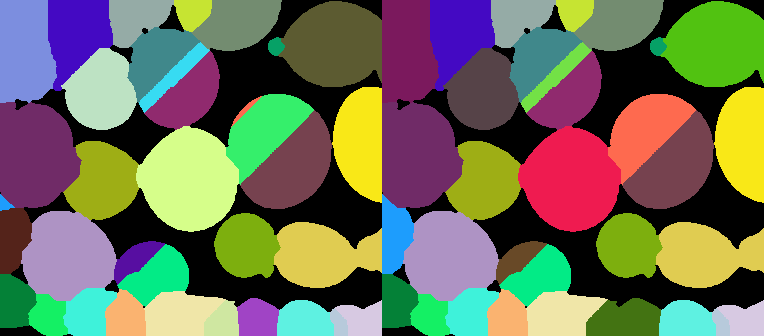

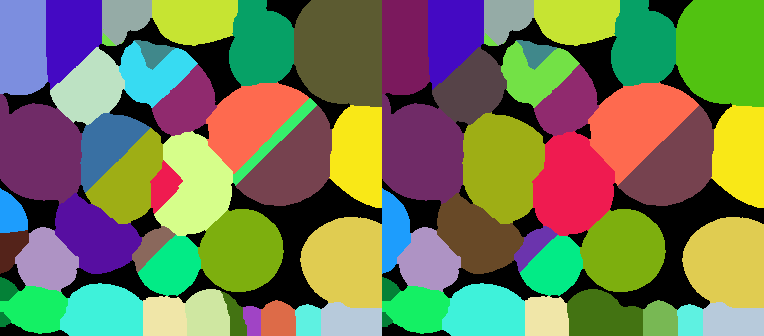

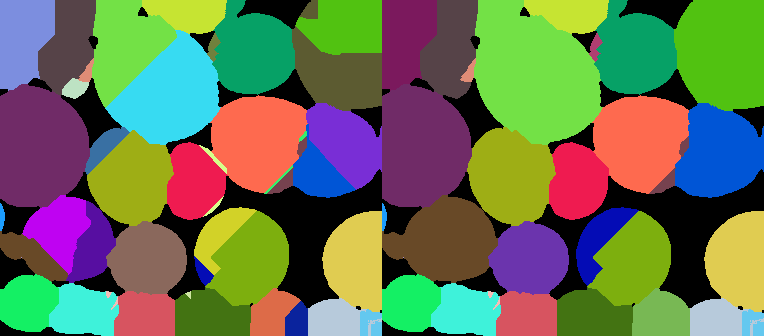

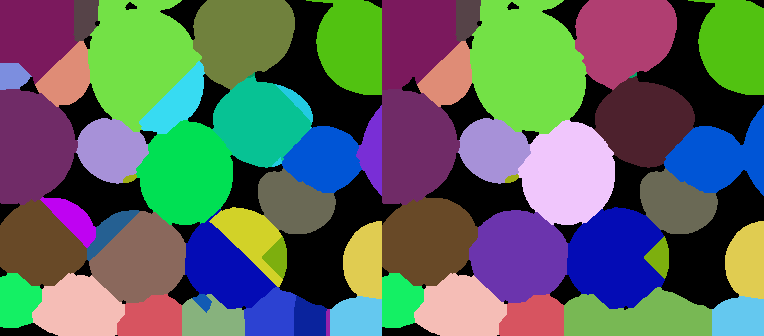

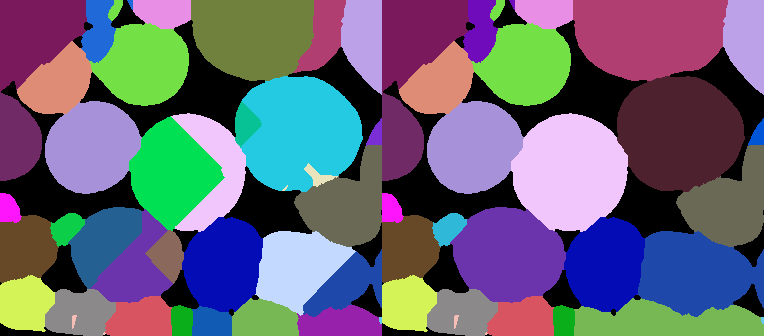

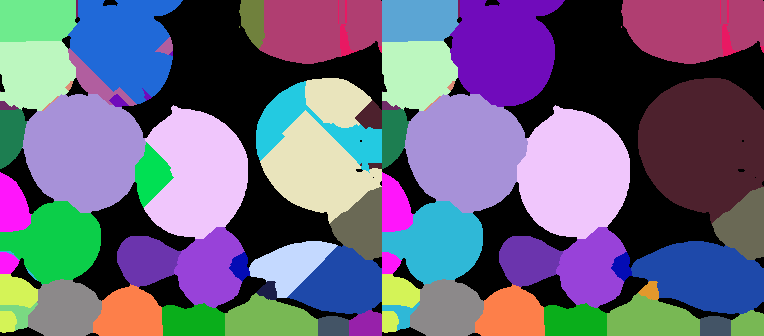

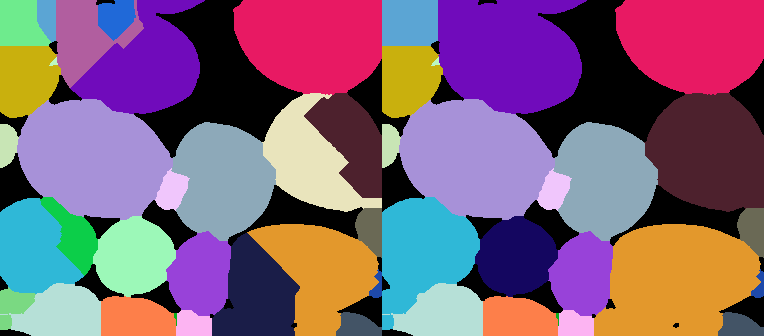

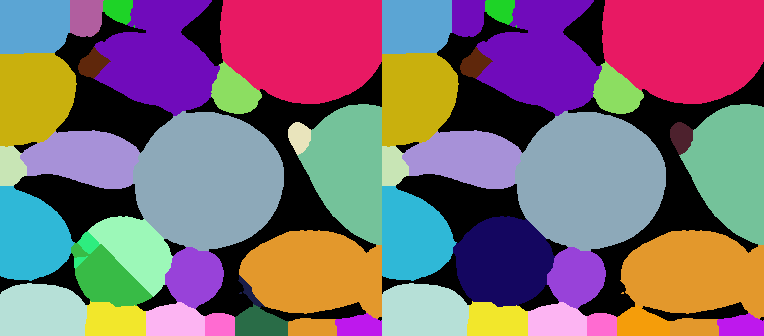

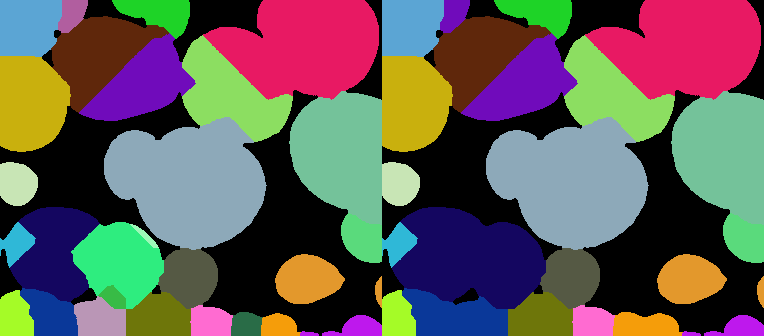

In [18]:
# find_root: Helper function for graph merging
# Input:
# - arr: array holding each cell's immediate upward connection
# - val: starting cell to check from
# Output: the 'root' of the starting cell -- that is, the single cell that has no further upwards connection
def find_root(arr, val):
  while arr[val] != val:
    val = arr[val]

  return val


cscores_list = [] # list of final concavity scores -- used for histogram display only
concavity_dict = dict() # used for mayavi output ONLY
hold = list(range(arrmax+1)) # array holding immediate upward connections

# taking geometric mean of middle (100n)% of array as determined by portion_size
for key in concavities:
  conc = 1; clen = len(concavities[key])
  if portion_size == 0:
    clist = [concavities[key][clen//2]] if clen > 0 else []
  else:
    clist = concavities[key][int(clen*(0.5 - portion_size/2)): int(clen*(0.5 + portion_size/2))]

  for val in clist:
    conc *= val # geometric mean of vals

  # if len(clist) = 0 (all checks tossed), decide not to merge --> final score = 0 below threshold
  concavity = conc ** (1/len(clist)) if len(clist) > 0 else 0
  concavity_dict[key] = concavity
  if len(clist) > 0: cscores_list.append(concavity) # don't add len(clist) = 0 failsafe to histogram

  if concavity > max_concav_threshold:
    # merge algorithm below: idea is when merging i and j, only link the root of i to the root of j
    # then reassign every cell to its root at the end
    # not necessarily intuitive; proof of correctness is included in a separate file
    curr_vals = list(map(lambda s : int(s), key.split()))
    roots = list(map(lambda v : find_root(hold, v), curr_vals))

    if roots[0] > roots[1]: roots = [roots[1], roots[0]]

    hold[roots[0]] = roots[1] # link smaller root to larger root


reassign = list(map(lambda v : find_root(hold, v), hold)) # reassign every cell to its root


# final pass through of the array, reassigning every ID in the dataset to its new value
print("Reassignment Time:")
final_arr = np.zeros(arr.shape)
for i in range(arr.shape[0]):
  for j in range(arr.shape[1]):
    for k in range(arr.shape[2]):
      final_arr[i][j][k] = reassign[int(merged_arr[i][j][k])]


# visualize different slices of the partial prune stage and final stage for comparison
# 'concatentate' puts them side by side for easier comparison
for z in range(0, arr.shape[2], 50):
  visualize(np.concatenate((merged_arr[:,:,z], final_arr[:,:,z]), axis=1), color=True)




Histogram Visualization:

Our 'Main Algorithm' section of the file is finished. So we move onto the 'Utilities' section, beginning with a histogram of our concavity scores (as shown in the presentation).

Recall that we grabbed a list of final concavity scores in the previous block. We simply use built-in matplotlib functionality to show a histogram. You can set fill = True for a histogram with filled bars, and fill = False for a histogram with unfilled bars. I set fill = True below.

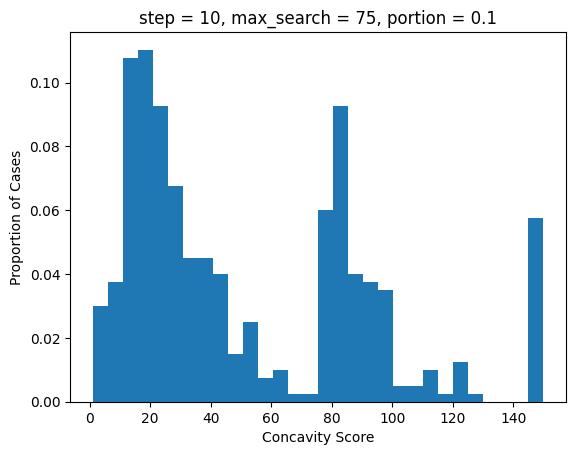

In [15]:
counts, bins = np.histogram(cscores_list, bins=30)

# giving figure a title + axis labels
title = "step = " + str(step) + ", max_search = " + str(max_search) + ", portion = " + str(portion_size)
plt.title(title)
plt.xlabel("Concavity Score")
plt.ylabel("Proportion of Cases")


plt.stairs(counts / len(cscores_list), bins, fill=True)


plt.show() # show histogram

Average Cell Volume Calculator:

This is the code I used to calculate a value for average cell volume, in the pursuit of automating my **step** and **max_search** parameters. It didn't really pan out, but I thought I should leave it in for documentation purposes.

The idea is to grab cells that we identify as 'correct,' and to take the average of the cube roots of their volume. This block does precisely that.

The **manual_coords** array at the top is a list of coordinates in the test dataset. Each coordinate belongs to a cell that we identify as 'correct.'

To create **manual_coords**, I would examine various slices of the final segmented version, identify cells that I thought were segmented correctly, manually find a coordinate belonging to that cell, and add it to the list myself. (On Mac, I did this by downloading a slice, visualizing it via Preview, and finding a corresponding coordinate that belongs to our 'good' cell on that slice.)

**NOTE**: The current **manual_coords** list belongs to the dataset **chunk_cell_0213.tif** -- or equivalently, loading in **0213.mat** to the first block of this notebook. These coordinates **will not work** with any other dataset!

Additionally, I used a similar process with the Ambrose dataset. (If you recall, the intent was to use the proportion in this average cube root of volume to 'apply' the parameters for Ambrose to 0213.) Since every cell in Ambrose is 'correct,' we don't need a list of 'proper_cell_ids.' Rather than checking if a cell is in proper_cell_ids, we need only check if it is a cell -- i.e. that it isn't 0.

<br>

After identifying correct cell IDs, this block loops through the segmented data and increments a volume counter for each pixel belonging to each correct cell. Then it takes the average of the cube roots as we want.







In [ ]:
# manually determined coordinates belonging to cells that I determined to be good
# in practice, must do this by checking slices or 3D visualizations of cells by eye
# THESE COORDINATES ONLY WORK ON 0213 -- MUST BE ADAPTED TO OTHER DATASETS

manual_coords = [[120, 150, 50], [200, 100, 50], [280, 180, 50], [260, 220, 50], [50, 250, 50], [130, 250, 50],
[120, 50, 100], [190, 170, 100], [250, 230, 100], [260, 40, 100], [260, 160, 100], [90, 250, 100],
[80, 60, 150], [50, 250, 150], [100, 200, 150], [260, 300, 150], [250, 100, 150], [120, 150, 150],
[70, 70, 200], [60, 200, 200], [180, 50, 200], [180, 260, 200], [50, 300, 200], [230, 180, 200],
[60, 160, 250], [60, 270, 250], [110, 120, 250], [180, 180, 250], [120, 280, 250], [260, 290, 250]]

# extract IDs of cells that are good
proper_cell_ids = list(map(lambda c : final_arr[c[0], c[1], c[2]], manual_coords))


hold_dict = dict()
# pass through the array
for k in range(1, arr.shape[2]-1):

  if k % (arr.shape[2] // 10) == 0:
    print(str(k // (arr.shape[2] // 10) * 10) + "% finished :(")

  for i in range(1, arr.shape[0]-1):
    for j in range(1, arr.shape[1]-1):

      curr = final_arr[i][j][k]

      if curr in proper_cell_ids: # use this if statement for 0213.mat
      # if curr != 0:             # use this if statement for Ambrose -- all cells are correct
        if curr not in hold_dict:
          hold_dict[curr] = 1 # incrementing a volume counter for each good cell (stored in dictionary hold_dict)
        else:
          hold_dict[curr] += 1

# get the average of the cube roots of all volume counters in hold_dict
cr_list = []
for key in hold_dict:
  cr_list.append(hold_dict[key] ** (1/3))

# print final result
print(sum(cr_list) / len(cr_list))

IndexError: ignored

Ambrose Ground-Truth Comparison:

**WARNING**: This block is highly space-intensive, and can crash runtimes with previously loaded variables! I recommend **not running this block** unless you want to regenerate its result!

This is the code I used to calculate the ground-truth overlap between my segmented version of Ambrose and the ground_truth manually segmented version. Here, I load in the final results of my algorithm on Ambrose manually (via final_arr_ambrose.npy, which is included in the directory). You can produce this by running the algorithm on Ambrose, exporting the result, and renaming it to 'final_arr_ambrose.npy'.

**NOTE**: This block is **highly memory intensive**, and Google Colab **may crash**! In order to test intersection properly, this block must store each cell pixel as (i, j, k) in a dictionary -- this requires lots of space! If this block crashes the runtime, disconnect and run this block again **without** running anything else. This should free up the space necessary to run this block to completion.

<br>

This block is generally intuitive in its function. First, for each image (segmentation output and ground truth) it collects a dictionary of all identified cells, storing each as a **set** of pixel tuples (i, j, k). That is to say:

- final_arr_dict[val] is a **set** of pixel tuples (i, j, k) that have value val in the final segmented output
- labeled_arr_dict[val] is a **set** of pixel tuples (i, j, k) that have value val in the labeled ground truth

**NOTE**: Using sets rather than lists here makes the code significantly faster!

Notably, final_arr_ambrose.npy is a labeled image, while ambrose_test_volume_labeled.tif is an RGB image. So 'val' has different formats for each.

<br>

Second, for each identified cell in the **labeled ground truth**, we check each potential match in the **final segmented result** by our determined metric -- |intersection(A, B)| / max(|A|, |B|). We choose the best match with the optimal result for this. Then, we append our accuracy to the list **omaxes** and append our best_match to the list **best_matches**.

(Alternatively, one could start with the final segmented result and match to the labeled ground truth. I felt the current process made more intuitive sense, and they will return similar results.)

<br>

Finally, we do two things:

(1) Print out the average accuracy, essentially the average of the list **omaxes**.

(2) Check whether **best_matches** is 1-1 with the final segmented result. Remember that we have assigned a 'best match' from the final segmented result to each cell in the labeled ground truth. We want to know whether any 'best match' is assigned to two labeled cells, or not assigned to any.

In practice, we iterate through the keys of final_arr_dict and check whether its key appears too little or too much in **best_matches** (i.e. not exactly 1 time). We print out the offending key in final_arr_dict if this happens -- but because we have perfect accuracy, this print statement never triggers.

**If this block crashes:** It is likely due to RAM overflow on Google Colab. Restart the runtime, run **the first import block and nothing else**, and then run this block again. It should run to completion.



In [ ]:
# imports and defining relevant data structures
imstack = Image.open("./ambrose_test_volume_labeled.tif")
final_arr = np.load("./final_arr_ambrose.npy")
final_arr_dict = dict()
labeled_arr_dict = dict()


for k in range(final_arr.shape[2]):
  imstack.seek(k)
  labeled_arr = np.array(imstack)

  if k % (final_arr.shape[2] // 10) == 0:
    print(str(k // (final_arr.shape[2] // 10) * 10) + "% finished :(")

  for i in range(final_arr.shape[0]):
    for j in range(final_arr.shape[1]):
      # grabbing relevant cell IDs for each pixel
      fval = int(final_arr[i, j, k])
      lval = (labeled_arr[i, j, 0], labeled_arr[i, j, 1], labeled_arr[i, j, 2])

      # adding each pixel to corresponding key in dictionary
      if fval != 0 and fval in final_arr_dict:
        final_arr_dict[fval].add((i, j, k))
      else:
        final_arr_dict[fval] = set(); final_arr_dict[fval].add((i, j, k))

      if lval != (0, 0, 0) and lval in labeled_arr_dict:
        labeled_arr_dict[lval].add((i, j, k))
      else:
        labeled_arr_dict[lval] = set(); labeled_arr_dict[lval].add((i, j, k))


# defining lists as described above
best_matches = []; omaxes = []

inc = 0
# loop through keys <-> cells in labeled ground truth
for lkey in labeled_arr_dict:
  omax = -1; best_match = -1
  inc += 1
  print(inc, "of", len(labeled_arr_dict))

  # and find best matching key in final segmented result
  for fkey in final_arr_dict:
    lcell = labeled_arr_dict[lkey]; fcell = final_arr_dict[fkey]
    # using max_B [ |intersection(A,B)| / max(|A|, |B|) ] as discussed
    ocurr = len(lcell.intersection(fcell)) / max([len(fcell), len(fcell)])
    if ocurr > omax:
      omax = ocurr; best_match = fkey

  omaxes.append(omax); best_matches.append(best_match)

# print out average % overlap between segmentation & ground truth
print("Average overlap of final segmentation and ground truth is:", sum(omaxes) / len(omaxes))


# find if any key is matched != once to any other
# shouldn't ever trigger in a perfect match
perfect = True
for fkey in final_arr_dict:
  if best_matches.count(fkey) != 1:
    perfect = False
    print("Count of", fkey, "is:", best_matches.count(fkey))
if perfect: print("Perfect Match!")



0% finished :(
10% finished :(
20% finished :(
30% finished :(
40% finished :(
50% finished :(
60% finished :(
70% finished :(
80% finished :(
90% finished :(
100% finished :(
1 of 17
2 of 17
3 of 17
4 of 17
5 of 17
6 of 17
7 of 17
8 of 17
9 of 17
10 of 17
11 of 17
12 of 17
13 of 17
14 of 17
15 of 17
16 of 17
17 of 17
Average overlap of final segmentation and ground truth is: 0.9975835635918486
Perfect Match!


MayaVi Output

The final section of this notebook is dedicated to outputting information to MayaVi. This block is designed to visualize the concavity algorithm behavior on a specified border.

This block consists of a single function **output_to_mayavi**, which takes in the *partial prune stage* **arr** and a border key **key**. **arr** is naturally produced by the above blocks as 'merged_arr,' and is usually loaded directly from there.

To visualize the border between segment ID i and segment ID j, the corresponding **key** is "i j" if i < j, or "j i" if j < i. **The lower segment ID is always first -- the key will fail if this isn't followed!**

<br>

Upon receiving this information, **output_to_mayavi** passes through the array collecting relevant information. A list of this information and how it is collected is as follows:

- A list of pixels on the **outside** of segment i so as to visualize the shape of segment i. We pass through **arr** and store any pixel that (1) belongs to segment i, and (2) is adjacent to a pixel that doesn't belong to segment i, so as to be on the edge of segment i. **Visualized in blue**

**NOTE**: Because I visualize using a point cloud in MayaVi, it benefits runtime to show as few pixels as possible. Sampling from the outside of segments is for this purpose.

- The same as above, but for segment j. The process is identical. **Visualized in green**

- A list of pixels of the border between segment i and segment j. We pass through **arr** checking adjacent pixel pairs. If one belongs to segment i and the other belongs to segment j, store the first pixel. **Visualized in white**

- The contents of scanlist (see the Perpendicular Search block), which as as follows:
  - A list of all pixels belonging to perpendicular checks that are **kept** in the final store calculation. **Visualized in red**
  - A list of all pixels belonging to perpendicular checks that are **dropped** in the final store calculation. **Visualized in light red**
  - A list of the edge pixels from which the perpendicular checks are extended, i.e. before the 'parallel step' phase. **Visualized in yellow**

- The [a,b,c,d] notation of the fit plane. **Plane visualized in gray.**

- The shape of arr. Not explicitly visualized, but used for drawing a bounding box + restricting the plane to a certain area.


<br>

After collecting this information, I use the Python zipfile module to turn each bullet point into a NumPy array, save them as .npy files in the cwd, and zip them into a zipfile labeled [key].zip. Example: for key "488 489", the corresponding zip file output will be "488 489.zip".

When you want to produce a new test case, run **output_to_mayavi(merged_arr, [key])**. Upon completion, the output [key].zip will be in the same directory as this file. Unfortu

This block's output is designed to be read by **visualize_3d.py**. Upon generating the zipfile, move it (if necessary) to the directory containing visualize_3d.py and unzip it. Then, run visualize_3d.py. It will prompt for a key -- insert the key you've created the test case for. The visualization will pop up in a second window.


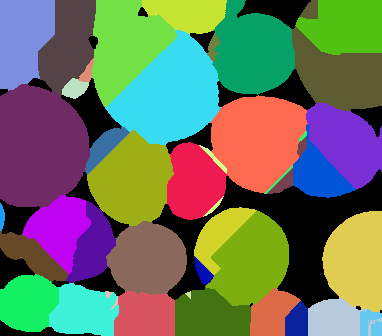

275.0 241.0


In [13]:
# how to get borders you want to visualize in MayaVi
# (1) After seeing them in the above slice comparison, save the corresponding slice to your cwd
visualize(merged_arr[:,:,100], save=True)
# (2) Download it to your machine (if on Google Colab)
# (3) On Mac, open it in Preview, and use the built-in tool to find pixels belonging to segments ID i and segment ID j
#     IMPORTANT: the x-axis and y-axis are reversed in the Preview tool <-> the array representation!
# (4) Print out the IDs of the pixels you identified. Make sure to order them in i<j order.
print(merged_arr[230, 220, 100], merged_arr[270, 250, 100])
# (5) Plug this key (format "i j", i < j) into output_to_mayavi(merged_arr, [key]) at bottom of below block
# (6) When block finishes, grab [key].zip and unzip it in the directory with visualize_3d.py
# (7) Run visualize_3d.py, and supply the key "i j" when prompted for a key.

In [14]:
def output_to_mayavi(arr, key):
  c1 = []
  c2 = []
  border_list = []

  # pass through the array
  for k in range(arr.shape[2]-1):

    if k % (arr.shape[2] // 10) == 0:
      print(str(k // (arr.shape[2] // 10) * 10) + "% finished :(")

    for i in range(arr.shape[0]-1):
      for j in range(arr.shape[1]-1):
        curr = masked_arr[i][j][k]
        # for use in collecting pixel pairs without double-counting
        adj_lst = [masked_arr[i+1][j][k], masked_arr[i][j+1][k], masked_arr[i][j][k+1]]
        # for checking full adjacency, used when determining 'edge' pixels for segments i and j
        adj_lst_1 = [masked_arr[i-1][j][k], masked_arr[i][j-1][k], masked_arr[i][j][k-1],
                               masked_arr[i+1][j][k], masked_arr[i][j+1][k], masked_arr[i][j][k+1]]
        border = False
        bhold = []

        vals = list(map(lambda s : int(s), key.split()))

        # append edge pixels of segment i to c1
        if curr == vals[0]:
          for a in adj_lst_1:
            if curr != a:
              c1.append((i, j, k)); break

        # append edge pixels of segment j to c2
        if curr == vals[1]:
          for a in adj_lst_1:
              if curr != a:
                c2.append((i, j, k)); break

        # append border pixels between segments i and j to border_list
        for a in range(len(adj_lst)):
          adj = adj_lst[a]
          if ([curr, adj] == vals or [adj, curr] == vals):
            border_list.append((i, j, k)); break


  np.save("cell_1", np.array(c1))
  np.save("cell_2", np.array(c2))
  np.save("borderlist", np.array(border_list))

  # load in the scanlist from the Perpendicular Check stage and read its information as described above
  # for how this information is collected, see the Perpendicular Check block above
  scanlist = scandict[key]
  np.save("scanlist", np.array(scanlist[0]))
  np.save("scanlist_f", np.array(scanlist[1]))
  np.save("edgelist", np.array(scanlist[2]))

  # also save the plane and the array shape as well
  np.save("plane", plane_dict[key])
  np.save("arrshape", np.array([arr.shape[0], arr.shape[1], arr.shape[2]]))


  # save all above information as NumPy arrays, and zip into [key].zip
  with zipfile.ZipFile(key + ".zip", 'w') as myzip:
    for fname in ['cell_1', 'cell_2', 'borderlist', 'scanlist', 'scanlist_f', 'edgelist', 'plane', 'arrshape']:
      myzip.write(fname + '.npy'); os.remove(fname + '.npy')

  myzip.close()

  # also prints final concavity score as a sanity check, can remove if desired
  print("Concavity:", concavity_dict[key])


output_to_mayavi(merged_arr, "241 275")


0% finished :(
10% finished :(
20% finished :(
30% finished :(
40% finished :(
50% finished :(
60% finished :(
70% finished :(
80% finished :(
90% finished :(
Concavity: 93.98928503186421


Ambrose MayaVi Visualization

This is designed to produce the visualization of the Ambrose segmentation as displayed in my presentation. It follows a similar idea to the visualization output above.

Again, we pass through the final segmented array, collecting information as we go. However, here we only must collect pixels belong to the edges of each segmented cell. In addition, we also collect pixels belonging to the top and bottom of the z-slice -- this makes the visualization look better.

Having collected a list of pixels corresponding to each identified cell, we save each as its own np array in the cwd. Then we zip everything up into a zipfile "ambrose.zip".

This block's output (i.e. the zipfile) is designed to be read by **visualize_ambrose.py**. Upon generating the zipfile, move it (if necessary) to the directory containing visualize_ambrose.py and unzip it. Then, simply run visualize_ambrose.py. Unlike **visualize_3d.py**, it requires no further input.

In [ ]:
import zipfile
# loads in the pre-calculated final ambrose array
# alternatively, can regenerate in this file with the Ambrose parameters mentioned above

# if you want to do this, run through this file w Ambrose data and comment this line out
# final_arr = np.load("./ambrose_final_arr.npy")
hold_dict = dict()

# pass through the array
for k in range(1, arr.shape[2]-1):

  for i in range(1, arr.shape[0]-1):
    for j in range(1, arr.shape[1]-1):

      # similar adjacency list to above -- must determine edge pixels
      curr = final_arr[i][j][k]
      adj_lst = [final_arr[i-1][j][k], final_arr[i][j-1][k], final_arr[i][j][k-1],
                               final_arr[i+1][j][k], final_arr[i][j+1][k], final_arr[i][j][k+1]]

      # if current pixel belongs to a cell + some adjacent pixel is air
      # OR pixel belongs to the top/bottom (z-direction) of the image -- better visualization
      if curr != 0 and (0 in adj_lst or k == 1 or k == arr.shape[2] - 2):
        if curr not in hold_dict:
          # then add to corresponding list of pixels (stored via dictionary)
          hold_dict[curr] = [(i, j, k)]
        else:
          hold_dict[curr].append((i, j, k))


# then output each list of pixels as its own NumPy array, and zip them all into ambrose.zip
with zipfile.ZipFile("ambrose.zip", 'w') as myzip:
  for key in hold_dict:
    fname = str(int(key)) # casts to a string version of integer (ex: 108.0 --> "108")
    np.save(fname, np.array(hold_dict[key]))

    myzip.write(fname + '.npy'); os.remove(fname + '.npy')

myzip.close()